<a href="https://colab.research.google.com/github/YusufCURUM/Alzheimer-s-Prediction/blob/main/Alzheimer's_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import sklearn as sk
import pandas as pd
import os

In [ ]:
#Read data
dat = pd.read_csv('ADNI_Training_Q3_APOE_CollectionADNI1Complete 1Yr 1.5T_July22.2014.csv')

#Check NA values, 1 NA for imputed_genotype
# dat.isnull().sum()

In [ ]:
dat = dat.dropna()
dat.isnull().sum().sum()

0

In [ ]:
#Peek at data
dat.head(3)

,directory.id,Subject,RID,Image.Data.ID,Modality,Visit,Acq.Date,DX.bl,EXAMDATE,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,APOE4,MMSE,imputed_genotype,APOE Genotype,Dx Codes for Submission
0,4702245ea294ce5d4e9b8a87027dfdf4,011_S_0003,3,32237,MRI,1,9/1/05,AD,9/12/05,81.3,Male,18,Not Hisp/Latino,White,1,20,True,"3,4",AD
1,2e89e352af743597b2368c412e0f6de2,022_S_0004,4,64631,MRI,1,9/22/05,LMCI,11/8/05,67.5,Male,10,Hisp/Latino,White,0,27,False,"3,3",MCI
2,90419199306997753de8042f1fd55e38,011_S_0005,5,32246,MRI,1,9/2/05,CN,9/7/05,73.7,Male,16,Not Hisp/Latino,White,0,29,True,"3,3",CN


In [ ]:
X = dat
Y = dat['DX.bl']
del dat

#Remove unnecessary columns (features), remove first 9 columns and 'Dx codes for submission'
remove_columns = list(X.columns)[0:9]
remove_columns.append('Dx Codes for Submission')
print('Removing columns:', remove_columns)

X = X.drop(remove_columns, axis=1)

features = list(X.columns)
X.head(5)

Removing columns: ['directory.id', 'Subject', 'RID', 'Image.Data.ID', 'Modality', 'Visit', 'Acq.Date', 'DX.bl', 'EXAMDATE', 'Dx Codes for Submission']


,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,APOE4,MMSE,imputed_genotype,APOE Genotype
0,81.3,Male,18,Not Hisp/Latino,White,1,20,True,"3,4"
1,67.5,Male,10,Hisp/Latino,White,0,27,False,"3,3"
2,73.7,Male,16,Not Hisp/Latino,White,0,29,True,"3,3"
3,80.4,Female,13,Not Hisp/Latino,White,0,25,True,"3,3"
4,73.9,Female,12,Not Hisp/Latino,White,1,24,True,"3,4"


In [ ]:
numerical_vars = ['AGE', 'MMSE', 'PTEDUCAT']
cat_vars = list(set(features) - set(numerical_vars))

print('Categorical variable distributions:\n')

for var in cat_vars:
    print('\nDistribution of', var)
    
    print(X[var].value_counts())

Categorical variable distributions:


Distribution of APOE4
0    322
1    234
2     71
Name: APOE4, dtype: int64

Distribution of APOE Genotype
3,3    275
3,4    221
4,4     71
2,3     45
2,4     13
2,2      2
Name: APOE Genotype, dtype: int64

Distribution of PTRACCAT
White    583
Black     31
Asian     13
Name: PTRACCAT, dtype: int64

Distribution of imputed_genotype
True     466
False    161
Name: imputed_genotype, dtype: int64

Distribution of PTGENDER
Male      363
Female    264
Name: PTGENDER, dtype: int64

Distribution of PTETHCAT
Not Hisp/Latino    616
Hisp/Latino          8
Unknown              3
Name: PTETHCAT, dtype: int64


Numerical Var Distributions:



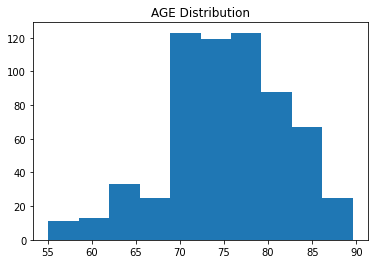

count    627.000000
mean      75.161882
std        6.689979
min       55.100000
25%       71.200000
50%       75.400000
75%       80.000000
max       89.600000
Name: AGE, dtype: float64


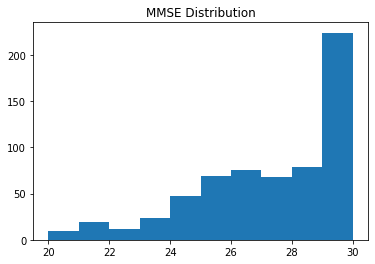

count    627.000000
mean      26.921850
std        2.563934
min       20.000000
25%       25.000000
50%       27.000000
75%       29.000000
max       30.000000
Name: MMSE, dtype: float64


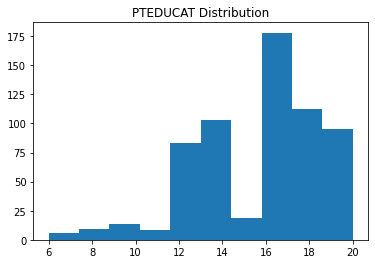

count    627.000000
mean      15.612440
std        2.978845
min        6.000000
25%       13.000000
50%       16.000000
75%       18.000000
max       20.000000
Name: PTEDUCAT, dtype: float64


In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

print('Numerical Var Distributions:\n')

for var in numerical_vars:
    plt.hist(X[var], bins=10)
    plt.title(var + ' Distribution')
    plt.show()
    
    # descriptive stats
    print(X[var].describe())

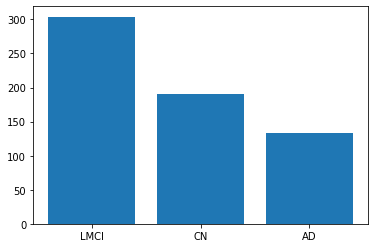

In [ ]:
plt.bar(Y.value_counts().index, Y.value_counts())
plt.show()

In [ ]:
#for each categorical var, convert to 1-hot encoding
for var in cat_vars:
    print('Converting', var, 'to 1-hot encoding')
    
    #get 1-hot and replace original column with the >= 2 categories as columns
    one_hot_df = pd.get_dummies(X[var])
    X = pd.concat([X, one_hot_df], axis=1)
    X = X.drop(var, axis=1)
    
X.head(4)

Converting APOE4 to 1-hot encoding
Converting APOE Genotype to 1-hot encoding
Converting PTRACCAT to 1-hot encoding
Converting imputed_genotype to 1-hot encoding
Converting PTGENDER to 1-hot encoding
Converting PTETHCAT to 1-hot encoding


,AGE,PTEDUCAT,MMSE,0,1,2,"2,2","2,3","2,4","3,3","3,4","4,4",Asian,Black,White,False,True,Female,Male,Hisp/Latino,Not Hisp/Latino,Unknown
0,81.3,18,20,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0
1,67.5,10,27,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,1,0,0
2,73.7,16,29,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0
3,80.4,13,25,1,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,1,0


In [ ]:
def normalize(X):
    """
    Normalize numerical variables for faster and better convergence
    
    Args:
        X (pd.DataFrame): data
        
    Returns:
        X (numpy array): same data but with normalized numerical features
    """

    #Convert to numpy array
    X = np.array(X)
    sanity_check = 0

    #Normalize numerical variables to speed up convergence
    for i in range(3):
        mean = np.mean(X[:, i])
        sd = np.std(X[:, i])
        print('\nNormalizing', numerical_vars[i], 'with mean=', format(mean, '.2f'), 'and sd=', format(sd, '.2f'))

        X[:, i] = (X[:, i] - mean) / sd
        sanity_check += np.mean(X[:, i])

    print('\nSanity Check. Sum of all the means should be near 0:', sanity_check)

    return X

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2)

print('X_train:', X_train.shape, '\ty_train:', y_train.shape)
print('X_test:', X_test.shape, '\ty_test:', y_test.shape)
num_test = X_test.shape[0]

X_train: (501, 22) 	y_train: (501,)
X_test: (126, 22) 	y_test: (126,)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [ ]:
log_clf = LogisticRegression(solver='lbfgs', penalty='l2', max_iter=1000000, multi_class='multinomial')
print('Validation Accuracy = ', format(cross_val_score(log_clf, X_train, y_train, cv=5).mean(), '.2%'))
log_clf.fit(X_train, y_train)
print("LogisticRegressio Teststing Accuracy", log_clf.score(X_test, y_test)*100,"%")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/l

Validation Accuracy =  71.07%
LogisticRegressio Teststing Accuracy 67.46031746031747 %


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
rf_clf = RandomForestClassifier(n_estimators=200)
print('Validation Accuracy = ', format(cross_val_score(rf_clf, X_train, y_train, cv=5).mean(), '.2%'))
rf_clf.fit(X_train, y_train)
print("RandomForestClassifier Teststing Accuracy", rf_clf.score(X_test, y_test)*100,"%")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/l

Validation Accuracy =  63.88%
RandomForestClassifier Teststing Accuracy 62.698412698412696 %


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
knn_clf = KNeighborsClassifier(n_neighbors=10)
print('Validation Accuracy = ', format(cross_val_score(knn_clf, X_train, y_train, cv=5).mean(), '.2%'))
knn_clf.fit(X_train, y_train)
print("KNeighborsClassifier Teststing Accuracy", knn_clf.score(X_test, y_test)*100,"%")

Validation Accuracy =  66.28%
KNeighborsClassifier Teststing Accuracy 69.84126984126983 %


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/l

In [ ]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(15, 10), alpha=3, learning_rate='adaptive', max_iter=100000)
print('Validation Accuracy = ', format(cross_val_score(mlp_clf, X_train, y_train, cv=5).mean(), '.2%'))
mlp_clf.fit(X_train, y_train)
print("MLPClassifier Teststing Accuracy", mlp_clf.score(X_test, y_test)*100,"%")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/l

Validation Accuracy =  48.68%
MLPClassifier Teststing Accuracy 57.14285714285714 %


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
svc_clf = SVC()
print('Validation Accuracy = ', format(cross_val_score(svc_clf, X_train, y_train, cv=5).mean(), '.2%'))
svc_clf.fit(X_train, y_train)
print("SupportVectorClassification Teststing Accuracy", svc_clf.score(X_test, y_test)*100,"%")

Validation Accuracy =  47.50%
SupportVectorClassification Teststing Accuracy 52.38095238095239 %


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/l

In [ ]:
nb_clf = GaussianNB()
print('Validation Accuracy = ', format(cross_val_score(nb_clf, X_train, y_train, cv=5).mean(), '.2%'))
nb_clf.fit(X_train, y_train)
print("NaiveBayes Teststing Accuracy", nb_clf.score(X_test, y_test)*100,"%")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/l

Validation Accuracy =  28.35%
NaiveBayes Teststing Accuracy 25.396825396825395 %


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
dt_clf = DecisionTreeClassifier()
print('Validation Accuracy = ', format(cross_val_score(dt_clf, X_train, y_train, cv=5).mean(), '.2%'))
dt_clf.fit(X_train, y_train)
print("DecisionTreeClassifier Teststing Accuracy", dt_clf.score(X_test, y_test)*100,"%")

Validation Accuracy =  63.08%
DecisionTreeClassifier Teststing Accuracy 63.49206349206349 %


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/l

In [ ]:
rf_clf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'int', 'str']. An error will be raised in 1.2.
  FutureWarning,


RandomForestClassifier(n_estimators=200)

In [ ]:
# https://towardsdatascience.com/running-random-forests-inspect-the-feature-importances-with-this-code-2b00dd72b92e
feature_importances = pd.DataFrame(rf_clf.feature_importances_, index=X_train.columns, 
                                   columns=['Importance']).sort_values('Importance', ascending=False)
print(feature_importances[:10])

          Importance
MMSE        0.389780
AGE         0.278705
PTEDUCAT    0.146366
0           0.020369
Female      0.018889
Male        0.018376
True        0.016007
False       0.015567
3,3         0.013134
2,3         0.011027


In [ ]:
print("The new perdiction for [80, 18, 20, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1] result is:", log_clf.predict(np.array([[80, 18, 20, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1]])))

The new perdiction for [80, 18, 20, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1] result is: ['AD']


In [ ]:
print("The new perdiction for [50, 18, 30, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1] result is:", log_clf.predict(np.array([[50, 18, 30, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1]])))

The new perdiction for [50, 18, 30, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1] result is: ['CN']


In [ ]:
log_clf.fit(X_train, y_train)

log_clf_preds = log_clf.predict(X_test)
    
log_clf_accuracy = (log_clf_preds == y_test)
print('Test Accuracy =', format( np.sum(log_clf_accuracy)/num_test, '.2%'))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Test Accuracy = 67.46%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
misclassified_index = (log_clf_preds != y_test)

X_misclassified = X_test[misclassified_index]
y_misclassified = y_test[misclassified_index]
preds_misclassified = log_clf_preds[misclassified_index]

X_misclassified.head()

,AGE,PTEDUCAT,MMSE,0,1,2,"2,2","2,3","2,4","3,3","3,4","4,4",Asian,Black,White,False,True,Female,Male,Hisp/Latino,Not Hisp/Latino,Unknown
356,73.5,16,30,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0
614,77.6,16,24,0,1,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,1,0
420,74.4,12,29,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,1,0
140,73.4,13,28,1,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,1,0
337,73.8,18,30,1,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,1,0


In [ ]:
print('Pred'.ljust(5), 'Y')
print('-----------')

over_estimate = under_estimate = total_miss = 0
for pred, y in zip(preds_misclassified, y_misclassified):
    print(pred.ljust(5), y)
    
    if (y == 'CN' and pred == 'AD') or (y == 'AD' and pred == 'CN'):
        total_miss += 1
    
    if y == 'CN':
        over_estimate += 1
        
    elif y == 'AD':
        under_estimate += 1
    
    # y is 'LMCI'
    else:
        if pred == 'CN':
            under_estimate += 1
        elif pred == 'AD':
            over_estimate += 1

Pred  Y
-----------
CN    LMCI
AD    LMCI
CN    LMCI
LMCI  CN
CN    LMCI
CN    LMCI
AD    LMCI
AD    LMCI
CN    LMCI
LMCI  CN
LMCI  CN
CN    LMCI
CN    LMCI
LMCI  AD
LMCI  AD
AD    LMCI
LMCI  CN
CN    LMCI
CN    LMCI
CN    LMCI
CN    LMCI
CN    LMCI
CN    LMCI
AD    LMCI
LMCI  CN
LMCI  CN
LMCI  AD
CN    LMCI
AD    LMCI
LMCI  CN
AD    LMCI
LMCI  AD
CN    LMCI
LMCI  CN
AD    LMCI
LMCI  CN
AD    LMCI
AD    LMCI
LMCI  CN
LMCI  AD
LMCI  CN


In [ ]:
print('Model over-estimated severity of cognitive problems:', over_estimate)
print('Model under-estimated severity of cognitive problems:', under_estimate)
print('Model was way off (total miss):', total_miss)

Model over-estimated severity of cognitive problems: 21
Model under-estimated severity of cognitive problems: 20
Model was way off (total miss): 0


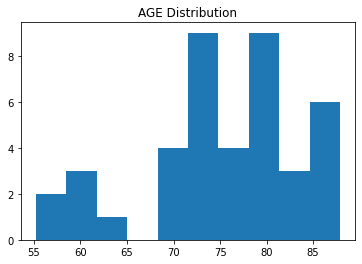

count    41.000000
mean     75.470732
std       8.473053
min      55.200000
25%      71.800000
50%      76.100000
75%      80.400000
max      87.900000
Name: AGE, dtype: float64


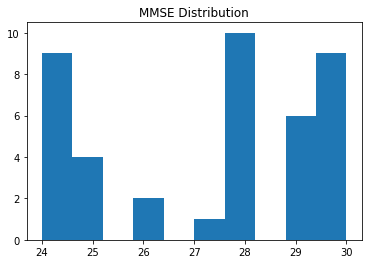

count    41.000000
mean     27.292683
std       2.293947
min      24.000000
25%      25.000000
50%      28.000000
75%      29.000000
max      30.000000
Name: MMSE, dtype: float64


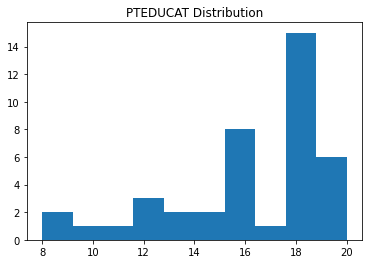

count    41.000000
mean     16.146341
std       3.198132
min       8.000000
25%      15.000000
50%      18.000000
75%      18.000000
max      20.000000
Name: PTEDUCAT, dtype: float64


In [ ]:
# DRY unless you're a data scientist
for var in ['AGE', 'MMSE', 'PTEDUCAT']:
    plt.hist(X_misclassified[var], bins=10)
    plt.title(var + ' Distribution')
    plt.show()
    
    # descriptive stats
    print(X_misclassified[var].describe())